# Goal

**Daegu Traffic Accident Damage Prediction AI Contest**

이동수단의 발달에 따라 다양한 유형의 교통사고들이 계속 발생하고 있습니다. 

한국자동차연구원과 대구디지털혁신진흥원에서는 해당 사고의 원인을 규명하고 사고율을 낮추기 위해, 

시공간 정보로부터 사고위험도(ECLO)를 예측하는 AI 알고리즘 발굴을 목표로 본 대회를 개최합니다. 



※ ECLO(Equivalent Casualty Loss Only) : 인명피해 심각도

**ECLO = 사망자수 * 10 + 중상자수 * 5 + 경상자수 * 3 + 부상자수 * 1**

본 대회에서는 사고의 위험도를 인명피해 심각도로 측정


# Word Description

**충돌** (각기 다른 방향에서 서로 부딪히는 경우)
![](https://img.hankyung.com/photo/202105/99.19292515.1-1200x.jpg)



**추돌** (같은 방향으로 달릴 때 혹은 정지 시 뒤에서 들이받는 경우) 
![](https://image.dongascience.com/Photo/2015/02/14239594278616.jpg)



**전복** (차가 뒤집어진 경우)
![](https://img.khan.co.kr/news/2020/09/15/l_2020091501001759700139001.jpg)


 
**전도** (차의 측면이 지면과 인접한 경우)
![](https://cdn.gukjenews.com/news/photo/201808/972842_747683_5459.jpg)

# Data Description

Dataset Info.

train.csv [파일] 
- ID : 대구에서 발생한 교통사고의 고유 ID
-2019년부터 2021년까지의 교통사고 데이터로 구성
- 해당 사고가 발생한 당시의 시공간 정보와 사고 관련 정보 포함 
- ECLO : 인명피해 심각도


test.csv [파일]
- ID : 대구에서 발생한 교통사고의 고유 ID
- 2022년도의 교통사고 데이터로 구성 
- 추론 시점에서 획득할 수 있는 정보로 구성


sample_submission.csv [파일] - 제출 양식
- ID : 추론 샘플의 고유 ID
- ECLO : 예측한 인명피해 심각도


대구 빅데이터 마트 데이터 [폴더]
- 대구 빅데이터활용센터에서 구축한 빅데이터 마트 데이터 중 제공 가능한 일부 데이터셋
- 상세한 명세는 폴더 내부의 빅데이터 마트 데이터 설명서.hwp 참고
- 전체 빅데이터 마트 데이터셋을 활용하기 위해서는 대구 빅데이터활용센터 방문 필요


countrywide_accident.csv [파일]
- 대구를 제외한 전국에서 발생한 교통사고 데이터
- 2019년부터 2021년까지의 교통사고 데이터로 구성 
- train.csv와 양식 동일


대구 보안등 정보.csv [파일] 
- 대구에 존재하는 보안등 관련 정보
 

대구 어린이 보호 구역 정보.csv [파일] 
- 대구에 존재하는 어린이 보호 구역 관련 정보


대구 주차장 정보.csv [파일] 
- 대구에 존재하는 주차장 관련 정보


대구 CCTV 정보.csv [파일] 
- 대구에 존재하는 CCTV 관련 정보

# Library

In [33]:
import warnings
warnings.filterwarnings('ignore')

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [32]:
#Regression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import rc
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

from sklearn.model_selection import KFold, cross_val_score, train_test_split, TimeSeriesSplit
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, VotingRegressor, StackingRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder,OrdinalEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.inspection import PartialDependenceDisplay
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import optuna

#automl
from pycaret.regression import *

# Datset

In [2]:
path = '/Users/baegnamjin/Desktop/Dataset/Daegu_Accident'

train = pd.read_csv(path + '/train.csv')
test = pd.read_csv(path + '/test.csv')
ss = pd.read_csv(path + '/sample_submission.csv')

train.drop(['ID'],axis=1, inplace=True)
test.drop(['ID'],axis=1, inplace=True)
#external

In [116]:
train.head()

,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,...,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO
0,2019-01-01 00,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,승용,...,상해없음,보행자,여,70세,중상,0,1,0,0,5
1,2019-01-01 00,화요일,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,보도통행중,기타,승용,...,상해없음,보행자,남,61세,경상,0,0,1,0,3
2,2019-01-01 01,화요일,맑음,대구광역시 수성구 두산동,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,승용,...,상해없음,보행자,남,38세,경상,0,0,1,0,3
3,2019-01-01 02,화요일,맑음,대구광역시 북구 복현동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,승용,...,상해없음,승용,남,36세,중상,0,1,0,0,5
4,2019-01-01 04,화요일,맑음,대구광역시 동구 신암동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,승용,...,상해없음,승용,남,52세,경상,0,0,1,0,3


In [117]:
test.head()

,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형
0,2022-01-01 01,토요일,맑음,대구광역시 수성구 상동,교차로 - 교차로안,건조,차대사람
1,2022-01-01 01,토요일,맑음,대구광역시 수성구 지산동,단일로 - 기타,건조,차대사람
2,2022-01-01 04,토요일,맑음,대구광역시 수성구 수성동2가,교차로 - 교차로안,건조,차대차
3,2022-01-01 04,토요일,맑음,대구광역시 수성구 신매동,단일로 - 기타,건조,차대차
4,2022-01-01 06,토요일,맑음,대구광역시 달서구 감삼동,교차로 - 교차로안,건조,차대차


# Wrangling

In [120]:
def wrangling(train_set, test_set):
    
    print("---Shape---")
    display(train_set.shape)
    display(test_set.shape)
    
    print("---Info----")
    display(train_set.info())
    display(test_set.info())
    
    print("---NaN----")
    display(train_set.isna().sum())
    display(test_set.isna().sum())
    
    print("---Duplicated---")
    display(train_set[train_set.duplicated()])
    display(test_set[test_set.duplicated()])
    
    print("---Description---")
    display(train_set.describe())
    display(test_set.describe())
    
    print("---Unique---")
    display(train_set.nunique())
    display(test_set.nunique())
    
wrangling(train,test)

---Shape---


(39609, 22)

(10963, 7)

---Info----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   사고일시         39609 non-null  object
 1   요일           39609 non-null  object
 2   기상상태         39609 non-null  object
 3   시군구          39609 non-null  object
 4   도로형태         39609 non-null  object
 5   노면상태         39609 non-null  object
 6   사고유형         39609 non-null  object
 7   사고유형 - 세부분류  39609 non-null  object
 8   법규위반         39609 non-null  object
 9   가해운전자 차종     39609 non-null  object
 10  가해운전자 성별     39609 non-null  object
 11  가해운전자 연령     39609 non-null  object
 12  가해운전자 상해정도   39609 non-null  object
 13  피해운전자 차종     38618 non-null  object
 14  피해운전자 성별     38618 non-null  object
 15  피해운전자 연령     38618 non-null  object
 16  피해운전자 상해정도   38618 non-null  object
 17  사망자수         39609 non-null  int64 
 18  중상자수         39609 non-null  int64 
 19  경상자수         

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10963 entries, 0 to 10962
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   사고일시    10963 non-null  object
 1   요일      10963 non-null  object
 2   기상상태    10963 non-null  object
 3   시군구     10963 non-null  object
 4   도로형태    10963 non-null  object
 5   노면상태    10963 non-null  object
 6   사고유형    10963 non-null  object
dtypes: object(7)
memory usage: 599.7+ KB


None

---NaN----


사고일시             0
요일               0
기상상태             0
시군구              0
도로형태             0
노면상태             0
사고유형             0
사고유형 - 세부분류      0
법규위반             0
가해운전자 차종         0
가해운전자 성별         0
가해운전자 연령         0
가해운전자 상해정도       0
피해운전자 차종       991
피해운전자 성별       991
피해운전자 연령       991
피해운전자 상해정도     991
사망자수             0
중상자수             0
경상자수             0
부상자수             0
ECLO             0
dtype: int64

사고일시    0
요일      0
기상상태    0
시군구     0
도로형태    0
노면상태    0
사고유형    0
dtype: int64

---Duplicated---


,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,...,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO
3360,2019-04-05 11,금요일,맑음,대구광역시 수성구 매호동,단일로 - 기타,건조,차대차,측면충돌,안전운전불이행,승용,...,상해없음,승용,여,37세,경상,0,0,1,0,3


,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형
758,2022-01-27 13,목요일,맑음,대구광역시 동구 효목동,교차로 - 교차로안,건조,차대차
994,2022-02-07 07,월요일,맑음,대구광역시 서구 내당동,단일로 - 기타,건조,차대차
1185,2022-02-14 17,월요일,맑음,대구광역시 남구 봉덕동,단일로 - 기타,건조,차대차
1633,2022-03-03 08,목요일,맑음,대구광역시 서구 비산동,단일로 - 기타,건조,차대차
2527,2022-04-06 08,수요일,맑음,대구광역시 북구 태전동,교차로 - 교차로안,건조,차대차
3246,2022-04-29 08,금요일,비,대구광역시 달서구 상인동,단일로 - 기타,젖음/습기,차대차
3330,2022-05-01 18,일요일,맑음,대구광역시 달서구 송현동,단일로 - 기타,건조,차대차
3360,2022-05-02 20,월요일,비,대구광역시 달서구 상인동,교차로 - 교차로안,젖음/습기,차대차
3817,2022-05-15 15,일요일,맑음,대구광역시 수성구 만촌동,단일로 - 기타,건조,차대차
3888,2022-05-17 17,화요일,맑음,대구광역시 북구 노원동3가,단일로 - 기타,건조,차대차


---Description---


,사망자수,중상자수,경상자수,부상자수,ECLO
count,39609.000000,39609.000000,39609.000000,39609.000000,39609.000000
mean,0.007776,0.262365,1.070085,0.126865,4.726704
std,0.090109,0.500845,0.992034,0.394670,3.207206
min,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,3.000000
50%,0.000000,0.000000,1.000000,0.000000,3.000000
75%,0.000000,0.000000,1.000000,0.000000,6.000000
max,2.000000,6.000000,22.000000,10.000000,74.000000


,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형
count,10963,10963,10963,10963,10963,10963,10963
unique,5548,7,5,192,11,6,3
top,2022-11-10 18,금요일,맑음,대구광역시 남구 대명동,단일로 - 기타,건조,차대차
freq,10,1743,10321,422,5039,10394,8559


---Unique---


사고일시           18057
요일                 7
기상상태               6
시군구              199
도로형태              11
노면상태               6
사고유형               3
사고유형 - 세부분류       14
법규위반              11
가해운전자 차종          12
가해운전자 성별           3
가해운전자 연령          89
가해운전자 상해정도         6
피해운전자 차종          13
피해운전자 성별           3
피해운전자 연령          97
피해운전자 상해정도         6
사망자수               3
중상자수               7
경상자수              18
부상자수               9
ECLO              46
dtype: int64

사고일시    5548
요일         7
기상상태       5
시군구      192
도로형태      11
노면상태       6
사고유형       3
dtype: int64

# Preprocessing

In [5]:
#변수형 변경
import re
def extract_and_convert_to_int(data):
    numbers = re.findall(r'\d+', str(data))
    return int(numbers[0]) if numbers else np.nan

train['가해운전자 연령'] = train['가해운전자 연령'].apply(extract_and_convert_to_int)
train['피해운전자 연령'] = train['피해운전자 연령'].apply(extract_and_convert_to_int)

# EDA

In [6]:
num_cols = train.select_dtypes(exclude='object').columns.tolist()
cat_cols = train.select_dtypes(include='object').columns.tolist()

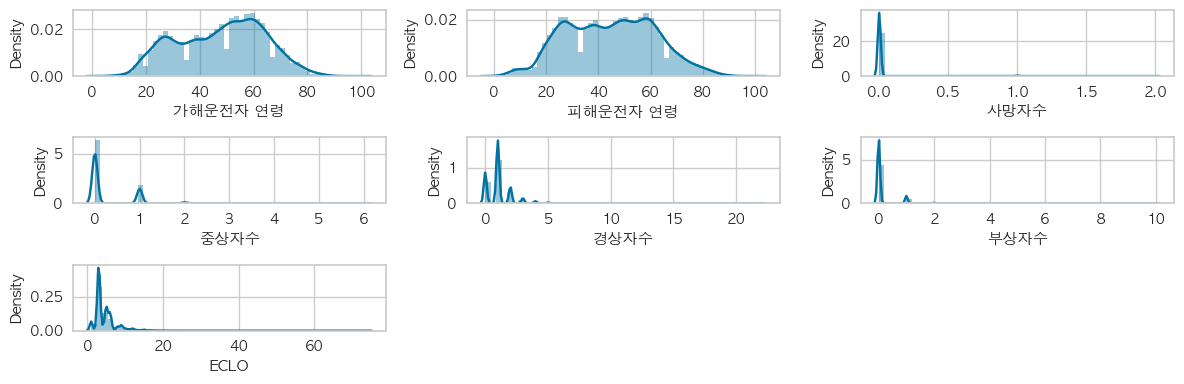

In [34]:
i = 0 
plt.figure(figsize=(12,4))
for col in num_cols:
    i += 1
    plt.subplot(3,3,i)
    sns.distplot(train[col])
plt.tight_layout()

**Insight**

- 사망까지 이른 경우는 많지 않지만 치명적인 사고가 됨
- 부상자수가 높았던 사건이 있음

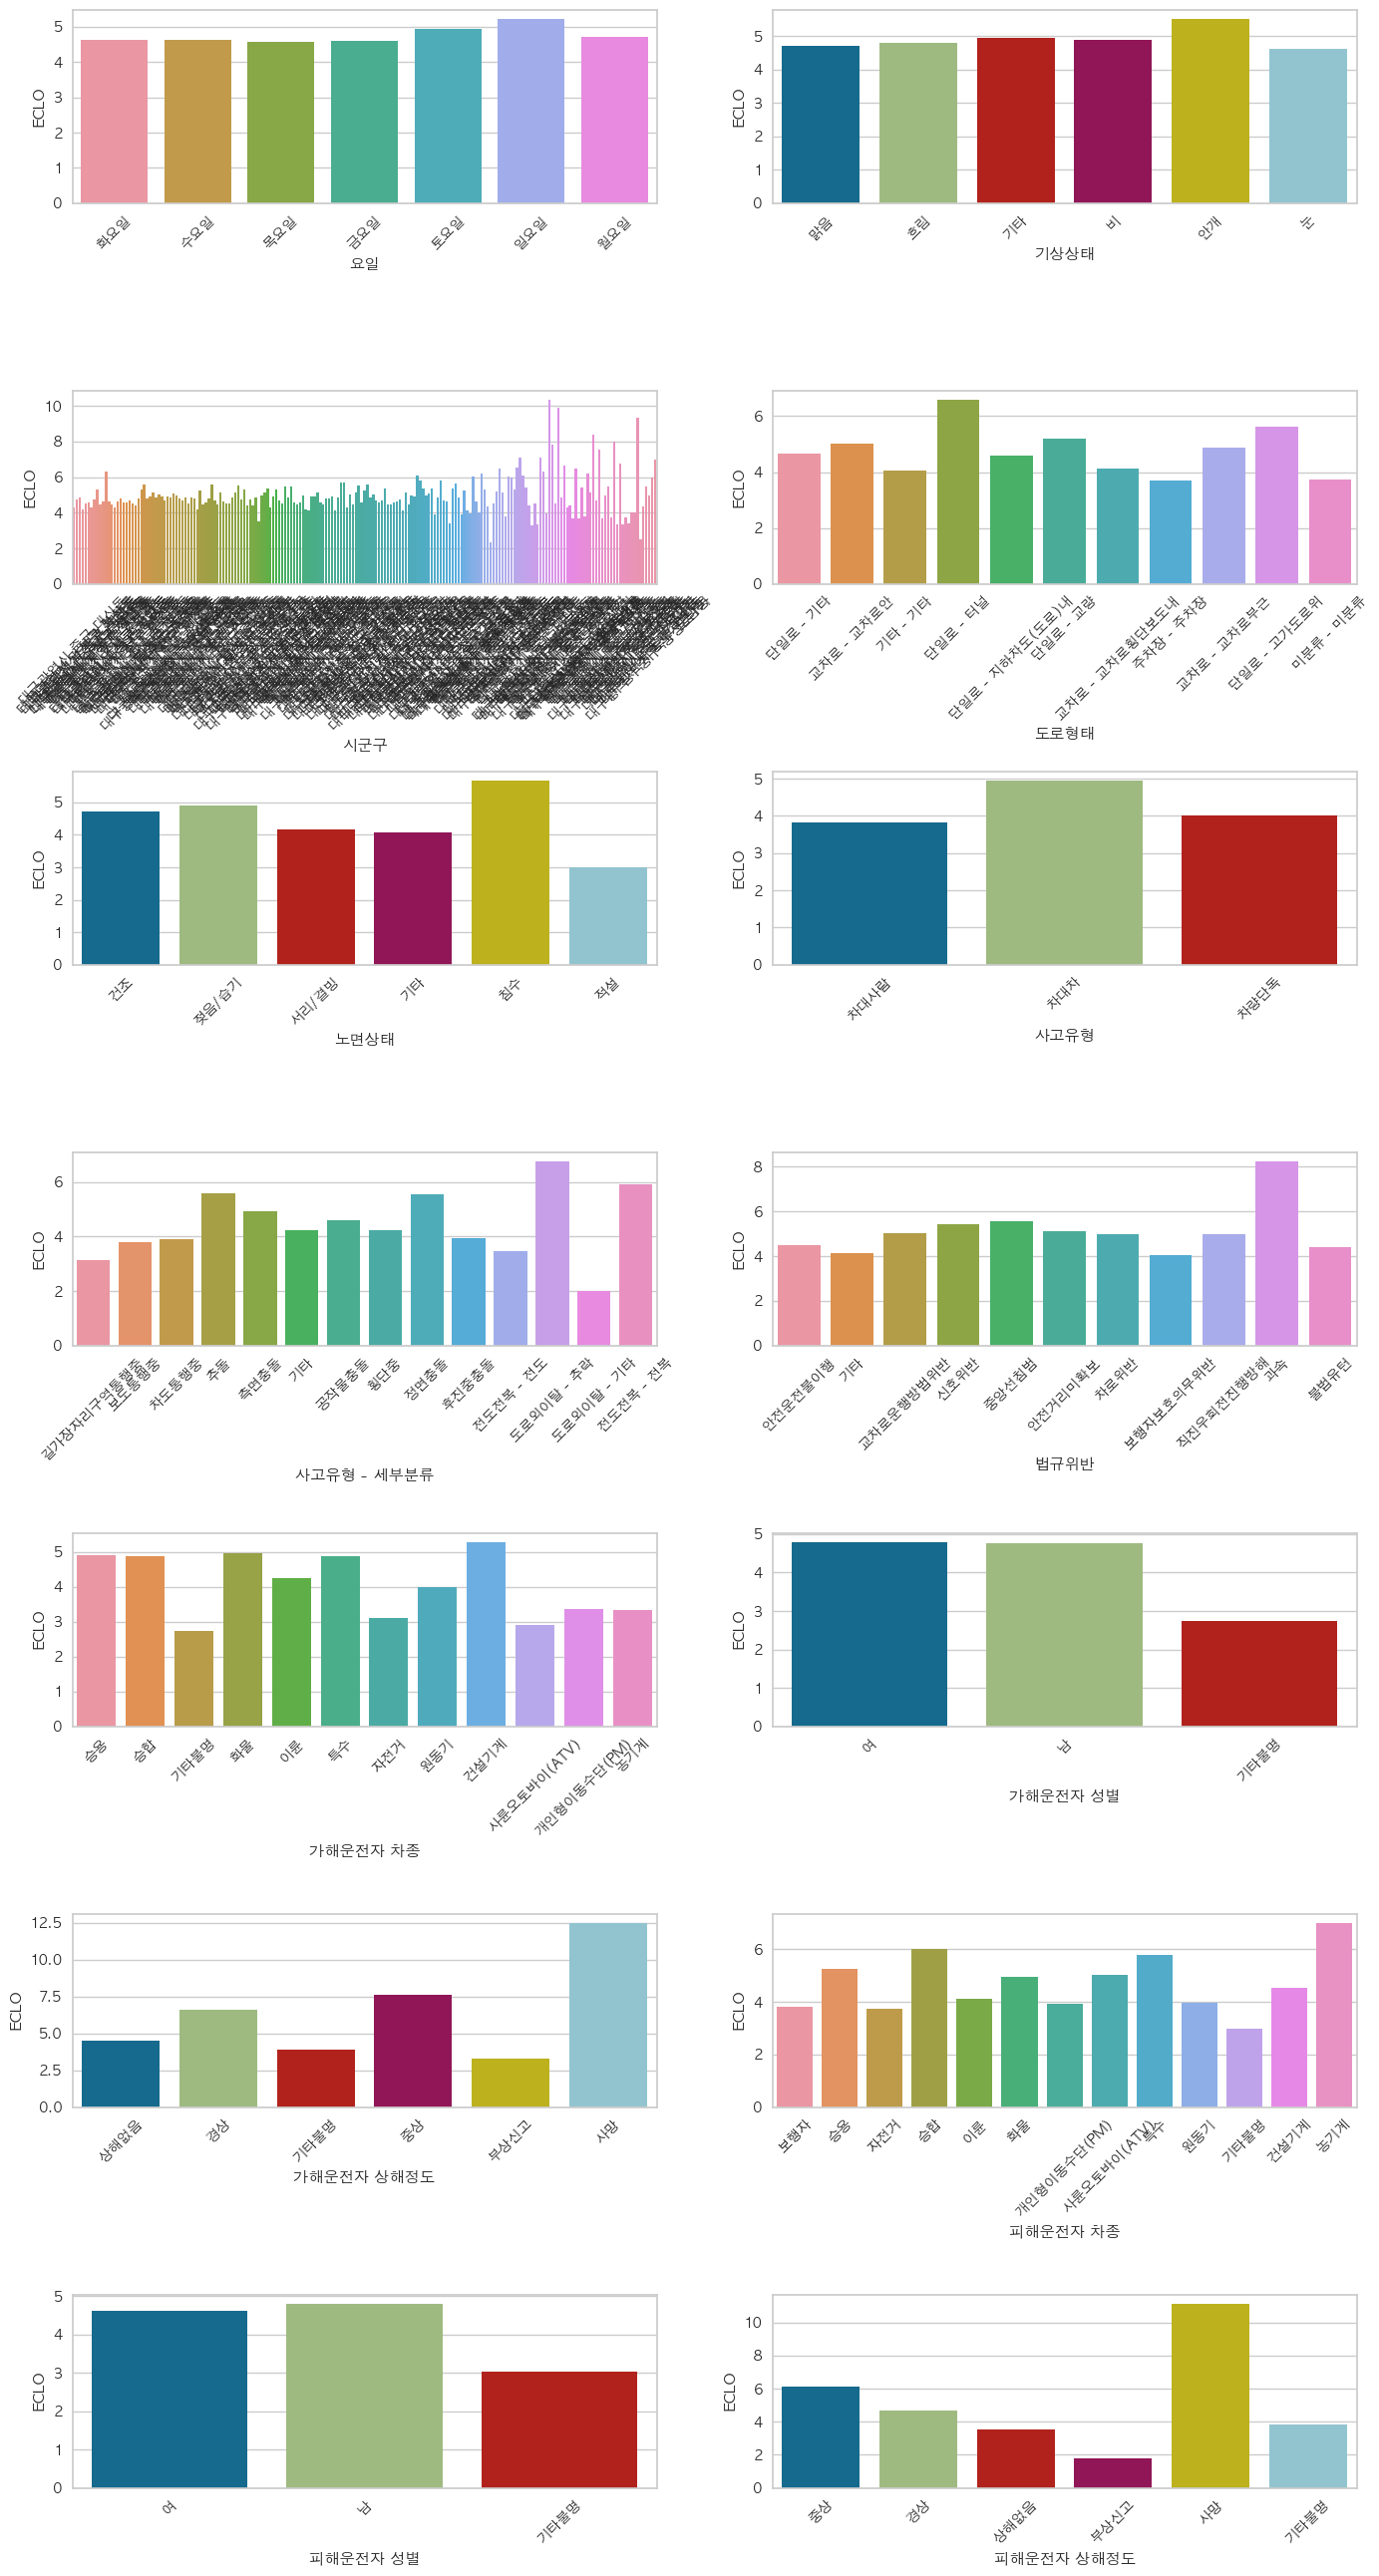

In [52]:
i = 0 
plt.figure(figsize=(14,26))
for col in ['요일',
 '기상상태',
 '시군구',
 '도로형태',
 '노면상태',
 '사고유형',
 '사고유형 - 세부분류',
 '법규위반',
 '가해운전자 차종',
 '가해운전자 성별',
 '가해운전자 상해정도',
 '피해운전자 차종',
 '피해운전자 성별',
 '피해운전자 상해정도']:
    i += 1
    plt.subplot(7,2,i)
    sns.barplot(x=train[col], y=train['ECLO'],ci=None)
    plt.xticks(rotation=45)
plt.tight_layout()

**Insight**

- 토요일, 일요일의 경우 보다 ECLO가 높음
- 안개가 낀 상황에 ECLO가 높음
- 특정 시군구에서 ECLO가 높음
- 단일로 - 터널의 경우 ECLO가 높음
- 노면상태가 침수인 경우 ECLO가 높았으며 반대로, 적설인 경우 ECLO가 낮음
- 차vs사람 보다 차vs차일 때 ECLO가 높음
- 법규위반이 과속인 경우 ECLO가 높음
- 가해운전자 차종이 승용, 승합, 화물, 건설기계인 경우 ECLO가 높음
- 가해운전자 성별에 따른 차이는 보이지 않음
- 피해운전자 차종이 농기계인 경우 ECLO가 높음

# Hypothesis

## 어느 시군구에서 ECLO가 높고 낮았을까?

In [127]:
num_by_region = train.groupby(['시군구'])['ECLO'].mean().sort_values(ascending=False)
print("높은 ECLO")
display(num_by_region[:10])
print()
print("낮은 ECLO")
display(num_by_region[-10:])

높은 ECLO


시군구
대구광역시 북구 노곡동    10.333333
대구광역시 동구 덕곡동     9.875000
대구광역시 중구 대안동     9.333333
대구광역시 동구 내동      8.400000
대구광역시 중구 하서동     8.000000
대구광역시 동구 진인동     7.823529
대구광역시 동구 둔산동     7.571429
대구광역시 북구 조야동     7.120000
대구광역시 동구 송정동     7.071429
대구광역시 북구 도남동     7.000000
Name: ECLO, dtype: float64


낮은 ECLO


시군구
대구광역시 동구 매여동      3.666667
대구광역시 중구 삼덕동1가    3.511013
대구광역시 중구 향촌동      3.400000
대구광역시 중구 수창동      3.392857
대구광역시 중구 서성로2가    3.333333
대구광역시 중구 북성로1가    3.333333
대구광역시 중구 화전동      3.333333
대구광역시 동구 미대동      3.300000
대구광역시 중구 종로2가     2.500000
대구광역시 중구 동일동      2.333333
Name: ECLO, dtype: float64

## 구와 동에 따른 ECLO

In [25]:
train['구'] = train['시군구'].str.split(" ",expand=True)[1]
train['동'] = train['시군구'].str.split(" ",expand=True)[2]

In [47]:
display(train.groupby(['구'])['ECLO'].mean().nlargest(10))
display(train.groupby(['동'])['ECLO'].mean().nlargest(10))

구
달성군    5.072280
동구     4.889534
서구     4.775680
수성구    4.727300
북구     4.687669
남구     4.623681
달서구    4.618441
중구     4.541610
Name: ECLO, dtype: float64

동
노곡동    10.333333
덕곡동     9.875000
대안동     9.333333
내동      8.400000
하서동     8.000000
진인동     7.823529
둔산동     7.571429
조야동     7.120000
송정동     7.071429
도남동     7.000000
Name: ECLO, dtype: float64

**Insight**

- 달성군에서 ECLO가 가장 큼
- 노곡동에서 ECLO가 가장 큼

달성군에는 중부내륙고속지선, 노곡동에는 신천대로가 있음  
**"고속도로에서 사고가 많이 일어나는 것인가?"**

## 가해운전자의 연령과 원인

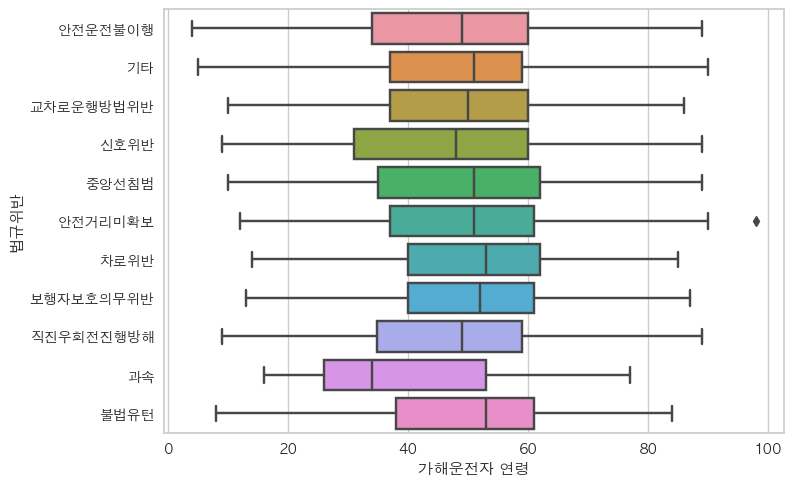

In [188]:
sns.boxplot(data=train, y='법규위반', x='가해운전자 연령')
plt.show()

**Insight**

- 10세 미만의 운전자도 보이며 가장 적은 가해운전자 연령은 4세임 (train['가해운전자'].min())
- 30대 초중반에 과속이 많음


## 가해운전자, 피해운전자의 연령에 따른 ECLO  
- 가정 1. 가해운전자 또는 피해운전자의 연령이 높은 경우 더 높은 ECLO를 나타낼 것이다. (선형적일 것이다.)

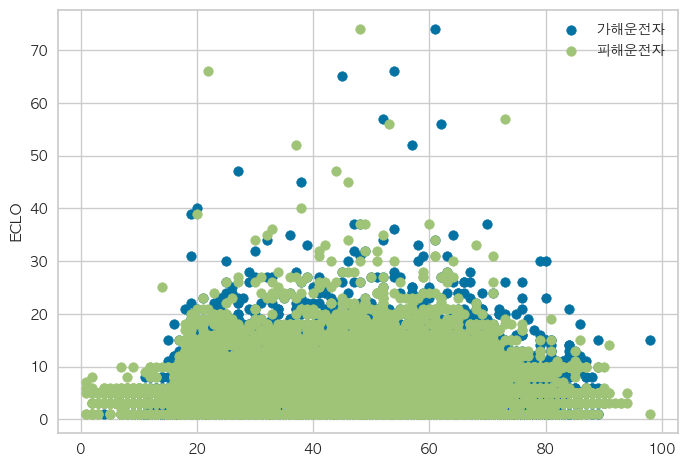

In [60]:
plt.scatter(x=train['가해운전자 연령'],y=train['ECLO'])
plt.ylabel("ECLO");

plt.scatter(x=train['피해운전자 연령'],y=train['ECLO'])
plt.ylabel("ECLO");
plt.legend(['가해운전자','피해운전자']);

**Insight**

- 가해운전자,피해운전자의 연령은 걱 ECLO와 선형적인 관계를 보이지 않음

## 시간에 따른 ECLO 
- 가정 1. 년도가 증가할수록 ECLO는 낮을 것이다.
- 가정 2. 공휴일이 있는 월에 ECLO가 높을 것이다.
- 가정 3. 출퇴근 시간에 ECLO가 높을 것이다.

In [102]:
train['년도'] = pd.to_datetime(train['사고일시']).dt.year
train['월'] = pd.to_datetime(train['사고일시']).dt.month
train['일'] = pd.to_datetime(train['사고일시']).dt.day
train['시간'] = pd.to_datetime(train['사고일시']).dt.hour

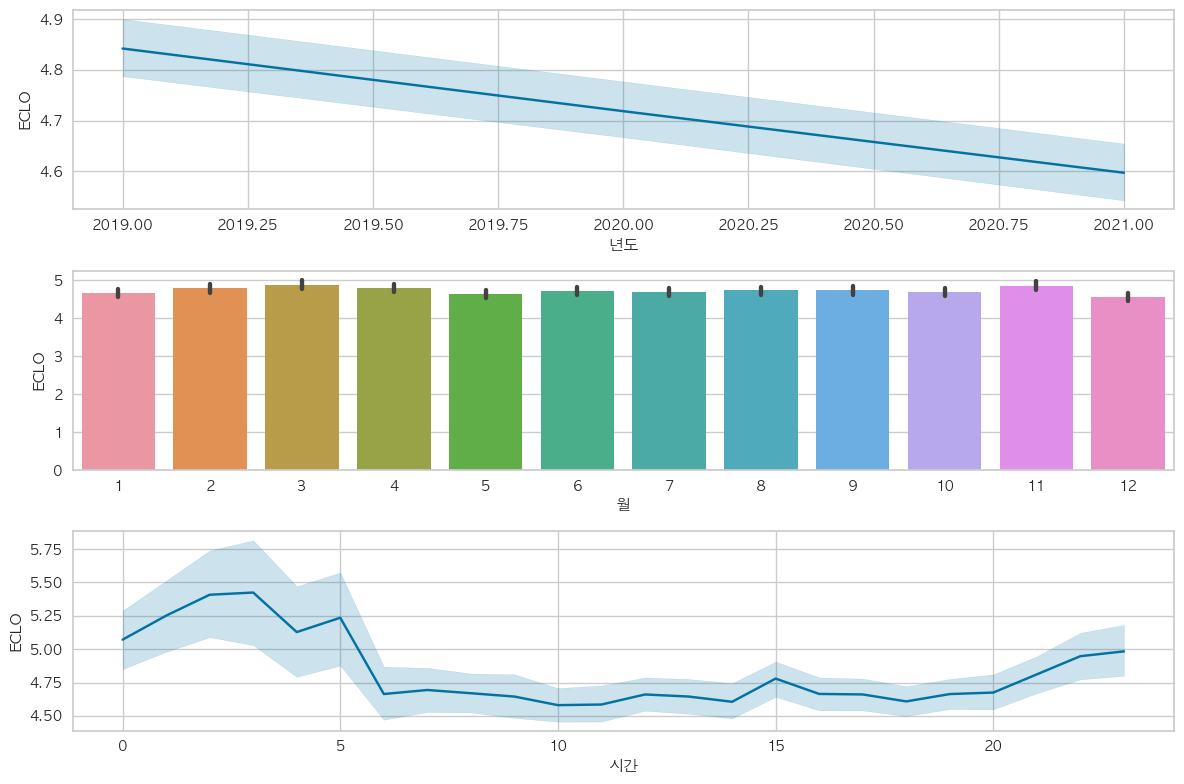

In [155]:
plt.figure(figsize=(12,8))
plt.subplot(3,1,1)
#가정 1. 년도가 증가할수록 교통사고는 낮을 것이다.
sns.lineplot(data=train, x='년도', y='ECLO')
plt.subplot(3,1,2)
#가정 2. 공휴일이 있는 월에 ECLO가 높을 것이다.
sns.barplot(data=train, x='월', y='ECLO')
plt.subplot(3,1,3)
#가정 3. 출퇴근 시간에 ECLO가 높을 것이다.
sns.lineplot(data=train, x='시간', y='ECLO')
plt.tight_layout();

**Insight**

- 연도가 증가할수록 ECLO는 낮음
- 공휴일에 있는 월(Month)과는 상관없어 보임
- 20시 이후 03시까지 ECLO가 높음

# 상관관계 분석

<AxesSubplot: >

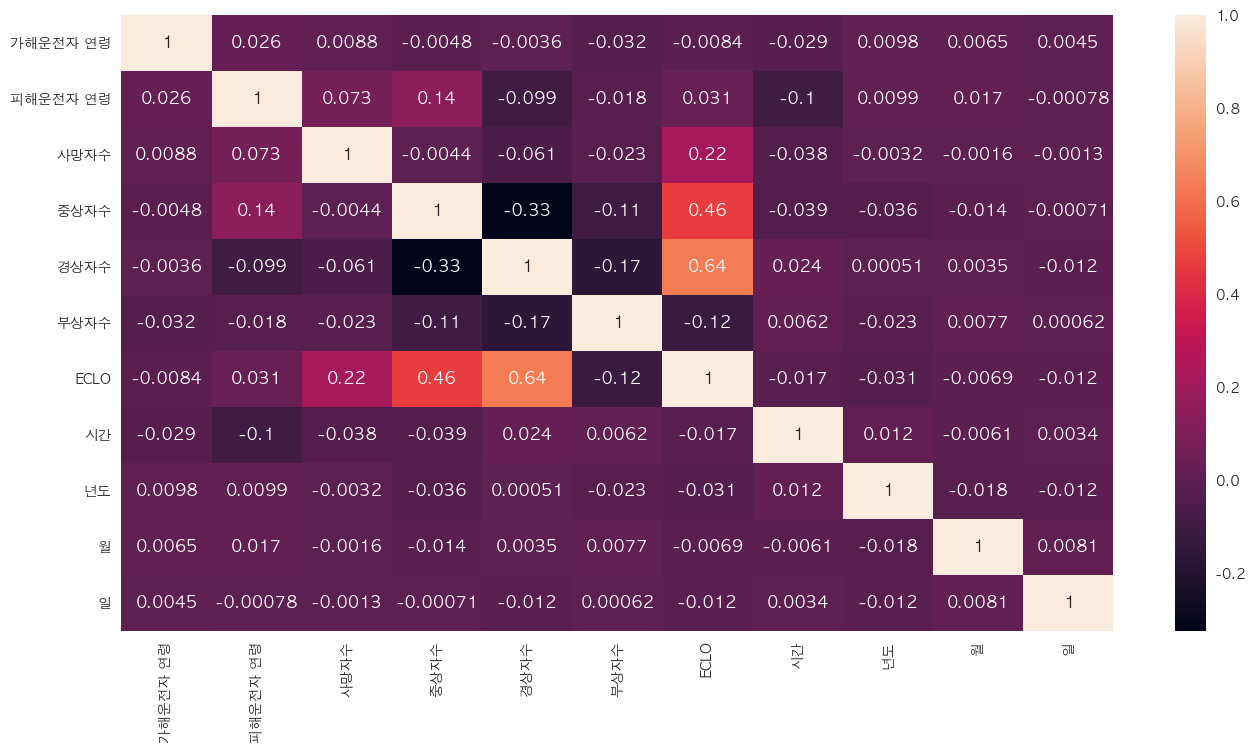

In [121]:
plt.figure(figsize=(16,8))
sns.heatmap(train.corr(), annot=True);